In [1]:
#Dependancies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import re
import scipy.stats as stats
import seaborn as sns
import time
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

sns.set(rc={'figure.figsize':(17,17)})


In [2]:
#Start the clock
t0=time.time()
starttime = pd.to_datetime(t0, unit='s')


In [3]:
# Import downloaded CSV as "starter data"
wines_csv = "winemag-data-130k-v2.csv"
wine_df = pd.read_csv(wines_csv)
wine_df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
# Lets take a look at what we are starting with
print([wine_df.count()])

[Unnamed: 0               129971
country                  129908
description              129971
designation               92506
points                   129971
price                    120975
province                 129908
region_1                 108724
region_2                  50511
taster_name              103727
taster_twitter_handle     98758
title                    129971
variety                  129970
winery                   129971
dtype: int64]


In [5]:
# Need to remove any early duplicates in data while data has most unique vales to eliminate duplicate entries
# but first have to get rid of old index
wine_df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
wine_df.drop_duplicates(subset=None, keep='first', inplace=True)
wine_df.count()

country                  119929
description              119988
designation               85443
points                   119988
price                    111593
province                 119929
region_1                 100428
region_2                  46769
taster_name               95071
taster_twitter_handle     90542
title                    119988
variety                  119987
winery                   119988
dtype: int64

In [6]:
# Drop unneeded columns, drop any records NaN and see what we are left with
wine_df2 = wine_df.drop(['description','designation','region_1', 'region_2', 
                         'taster_name', 'taster_twitter_handle'], axis=1).dropna()
print(wine_df2.count())
wine_df2.head()

country     111537
points      111537
price       111537
province    111537
title       111537
variety     111537
winery      111537
dtype: int64


,country,points,price,province,title,variety,winery
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [7]:
#Make copy of refined data to start working with (CWD = Clean Working Data)
CWD = wine_df2.copy()
#calculate new wine metric using price/adjusted rating point are from 80-100pts and add to CWD
CWD['new_wine_metric'] = CWD['price']/(CWD['points']-79)
CWD

,country,points,price,province,title,variety,winery,new_wine_metric
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1.875000
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,1.750000
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,1.625000
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,8.125000
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,1.875000
...,...,...,...,...,...,...,...,...
129966,Germany,90,28.0,Mosel,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2.545455
129967,US,90,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,6.818182
129968,France,90,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2.727273
129969,France,90,32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2.909091


In [8]:
#Basic Data
print('Basic analysis of price and point data:')
cal_count = CWD.loc[CWD['province'] == 'California']['new_wine_metric'].count()
noncal_count = CWD.loc[CWD['province'] != 'California']['new_wine_metric'].count()
print(f'Of the {len(CWD)} records, {cal_count} were reviews of Californian wines while {noncal_count} were not.')
cal_price = CWD.loc[CWD['province'] == 'California']['price']
noncal_price = CWD.loc[CWD['province'] != 'California']['price']
print(f'Californian wine has a price range of ${cal_price.min()} to ${cal_price.max()} with an avg. of ${cal_price.mean()}')
print(f'Non Californian wine has a price range of ${noncal_price.min()} to ${noncal_price.max()} with an avg. of ${noncal_price.mean()}')
cal_pts = CWD.loc[CWD['province'] == 'California']['points']
noncal_pts = CWD.loc[CWD['province'] != 'California']['points']
print(f'California wine is typically rated at about {cal_pts.mean()}pts, while Non Californian wine is rated at {noncal_pts.mean()}pts')
cal_nwm = CWD.loc[CWD['province'] == 'California']['new_wine_metric']
noncal_nwm = CWD.loc[CWD['province'] != 'California']['new_wine_metric']
print(f'California NWM = {cal_nwm.mean()}, NonCalifornia NWM = {noncal_nwm.mean()}')

Basic analysis of price and point data:
Of the 111537 records, 33526 were reviews of Californian wines while 78011 were not.
Californian wine has a price range of $4.0 to $2013.0 with an avg. of $39.17165781781304
Non Californian wine has a price range of $4.0 to $3300.0 with an avg. of $34.102613733960595
California wine is typically rated at about 88.61975779991648pts, while Non Californian wine is rated at 88.3253002781659pts
California NWM = 4.232813742212094, NonCalifornia NWM = 3.5215371357642464


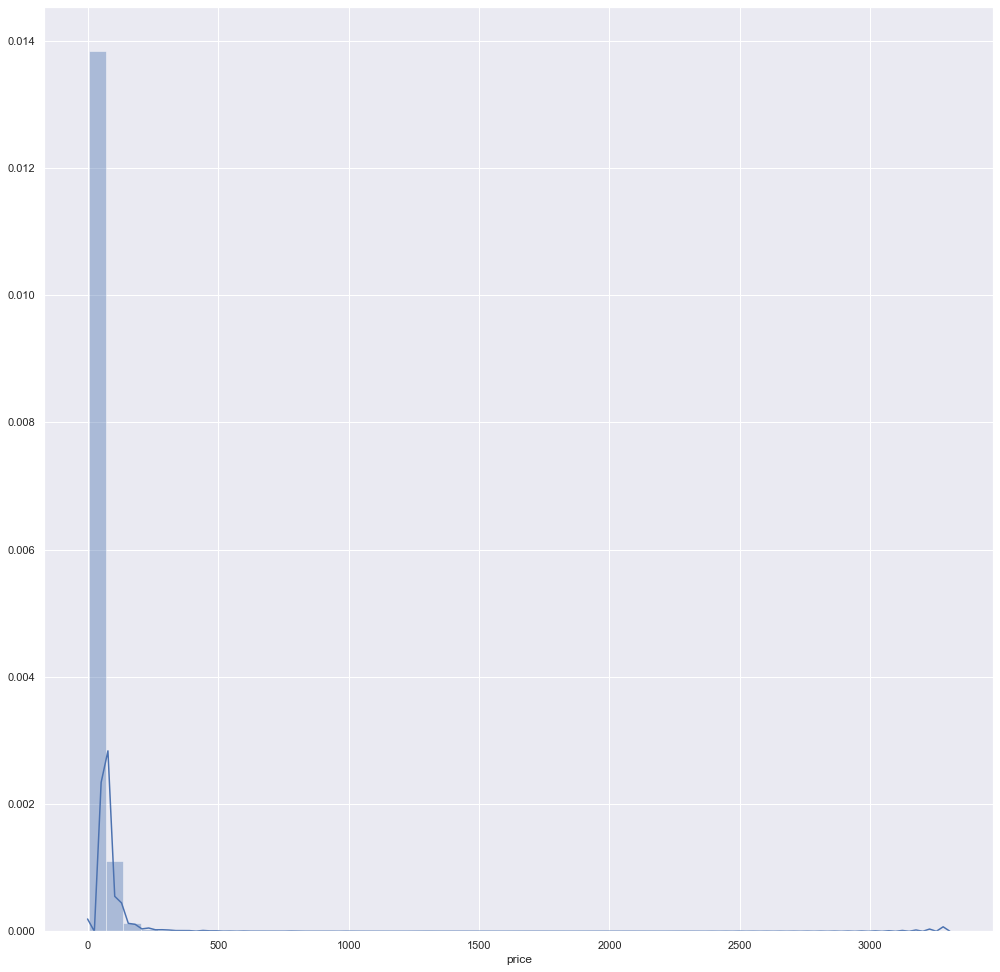

In [9]:
sns.distplot(CWD.price)
plt.savefig("Initial_Price_Data_Histogram.png")

In [10]:
total_wine_count = len(CWD)

# look at IQR for price
cwd_price_iqr = CWD['price']
cwd_quartiles = round(cwd_price_iqr.quantile([.25,.5,.75]),2)
cwd_lowerq = round(cwd_quartiles[0.25],2)
cwd_upperq = round(cwd_quartiles[0.75],2)
cwd_iqr = round(cwd_upperq-cwd_lowerq,2)

print('Total IQR price Data:')
print(f"The lower quartile of price for All Reviewed Wines is : {cwd_lowerq}")
print(f"The upper quartile of price for All Reviewed Wines is: {cwd_upperq}")
print(f"The interquartile range of pricee for All Reviewed Wines is: {cwd_iqr}")
print(f"The the median of price for All Reviewed Wines is: {cwd_quartiles[0.5]} ")

cwd_lower_bound = round(cwd_lowerq - (1.5*cwd_iqr),2)
cwd_upper_bound = round(cwd_upperq + (1.5*cwd_iqr),2)

# print(f"Values below {cal_lower_bound} could be outliers.")

print(f"Values above {cwd_upper_bound} could be outliers.")
cwd_upr_otlr_count = CWD['price'][CWD['price'] > [cwd_upper_bound][0]].count()
cwd_otlr_pct = (cwd_upr_otlr_count/total_wine_count)*100
print(f'Of the {total_wine_count} Californian wines, There are {cwd_upr_otlr_count} above the upper bounds or {cwd_otlr_pct.round(2)}%')


Total IQR price Data:
The lower quartile of price for All Reviewed Wines is : 17.0
The upper quartile of price for All Reviewed Wines is: 42.0
The interquartile range of pricee for All Reviewed Wines is: 25.0
The the median of price for All Reviewed Wines is: 25.0 
Values above 79.5 could be outliers.
Of the 111537 Californian wines, There are 6869 above the upper bounds or 6.16%


In [11]:
adj_cwd = CWD.loc[CWD['price'] < [cwd_upper_bound][0]]
adj_cwd

,country,points,price,province,title,variety,winery,new_wine_metric
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1.875000
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,1.750000
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,1.625000
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,8.125000
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,1.875000
...,...,...,...,...,...,...,...,...
129966,Germany,90,28.0,Mosel,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2.545455
129967,US,90,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,6.818182
129968,France,90,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2.727273
129969,France,90,32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2.909091


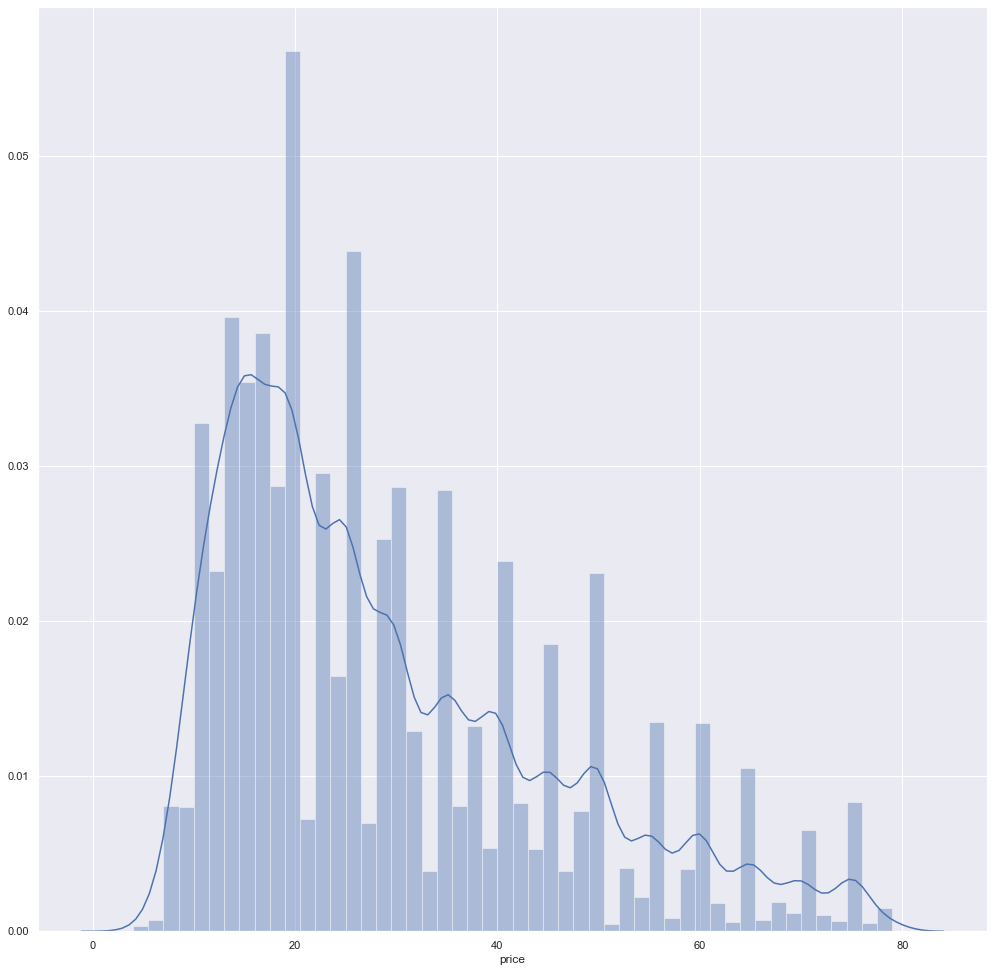

In [12]:
sns.distplot(adj_cwd.price)
plt.savefig("Adjusted_Price_Data_Histogram.png")

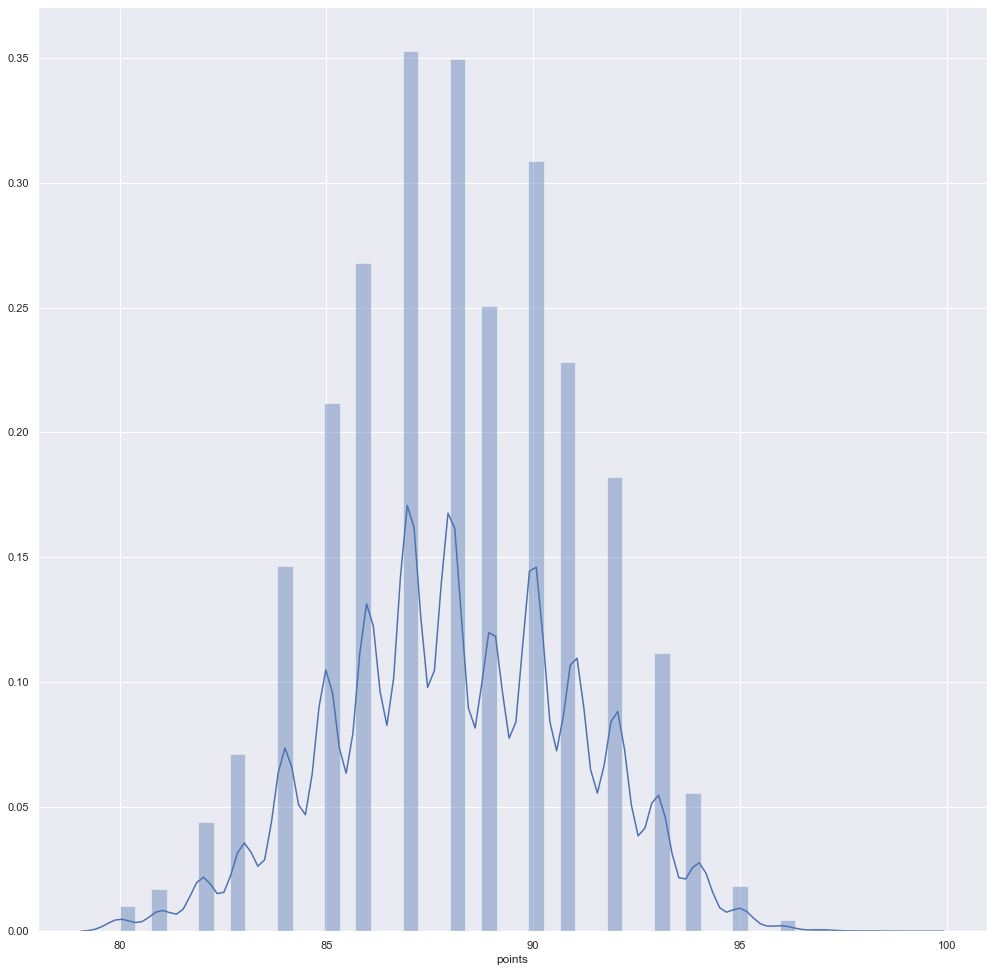

In [13]:
sns.distplot(adj_cwd.points)
plt.savefig("Adjusted_Review_Data_Histogram.png")

In [ ]:
sns.distplot(adj_cwd[adj_cwd.province=='California'].points)
plt.savefig("Adjusted_Review_Data_Histogram for California.png")

The total number of unique countries is 42
[country
US              47681
France          14685
Italy           14067
Spain            5732
Portugal         4330
Chile            4019
Argentina        3350
Austria          2466
Australia        1990
Germany          1782
New Zealand      1216
South Africa     1166
Israel            441
Greece            427
Canada            210
Bulgaria          131
Hungary           120
Romania           100
Uruguay            96
Turkey             80
Name: points, dtype: int64]


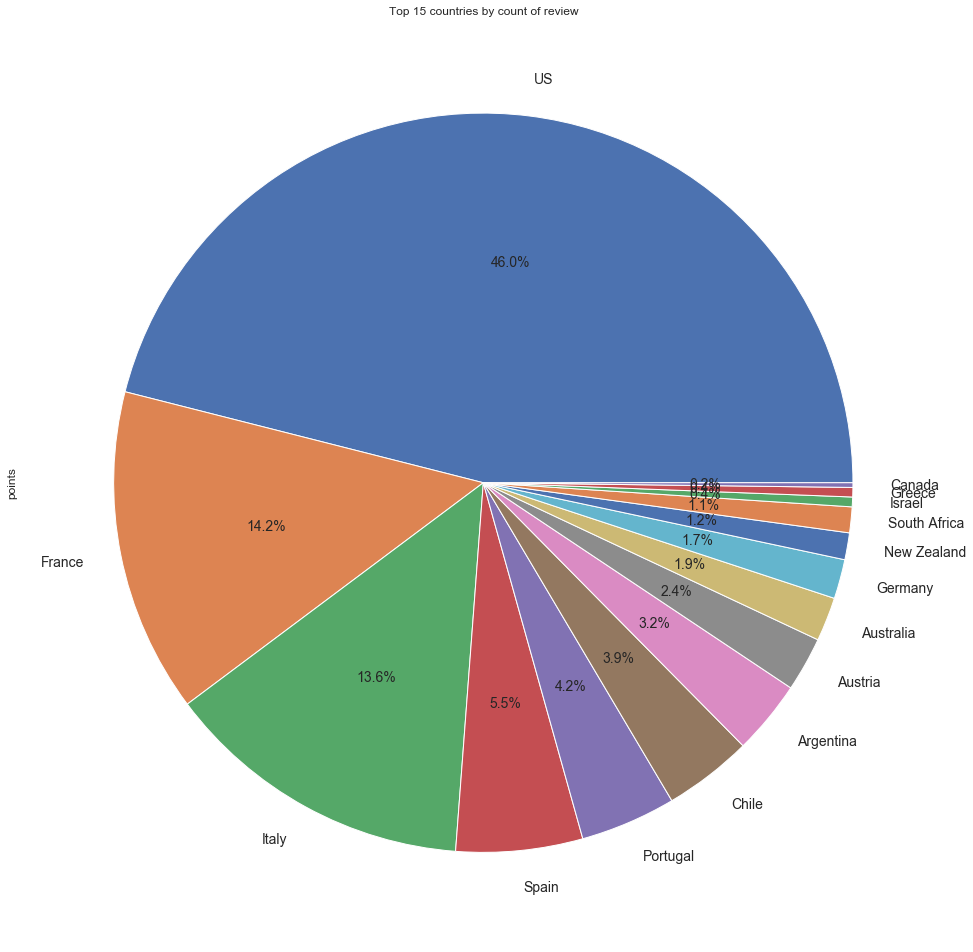

In [14]:
# See percentage of reviews by country for top 15
cwd_cntry = adj_cwd.groupby('country')
cwd_cntry_count = cwd_cntry['points'].count()

print(f'The total number of unique countries is {len(cwd_cntry_count.index)}')
print([cwd_cntry_count.sort_values(ascending=False).head(20)])

# Create pie plot of top 15 countries reviewed
t15_cwd_cntry_count = cwd_cntry_count.sort_values(ascending=False).head(15)

t15_cwd_cntry_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})
plt.title('Top 15 countries by count of review')
plt.savefig("top_15_reviewed_countries.png")

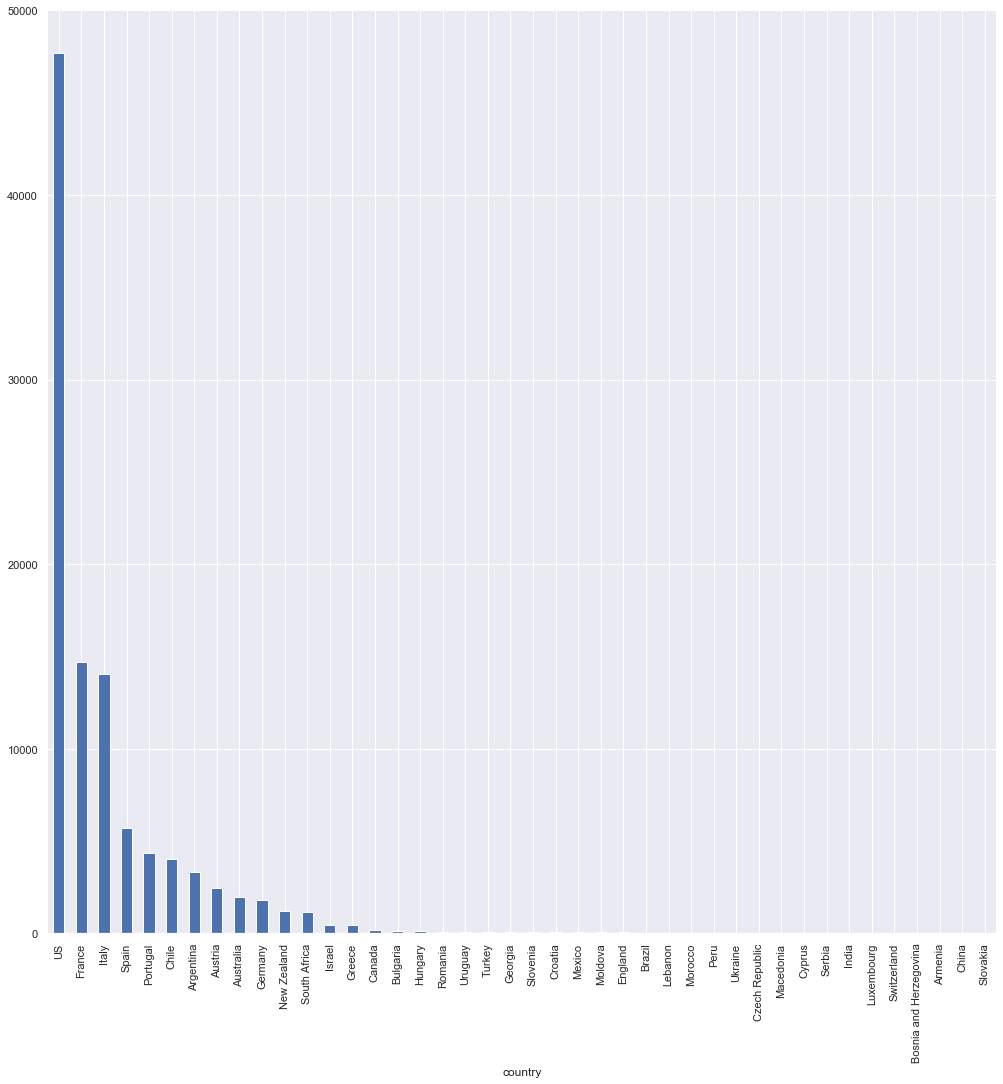

In [15]:
cwd_cntry_count.sort_values(ascending=False, inplace=True)
cwd_cntry_count.plot.bar(figsize=(17,17))
plt.savefig("Reviewed_countries_sorted_barplot.png")

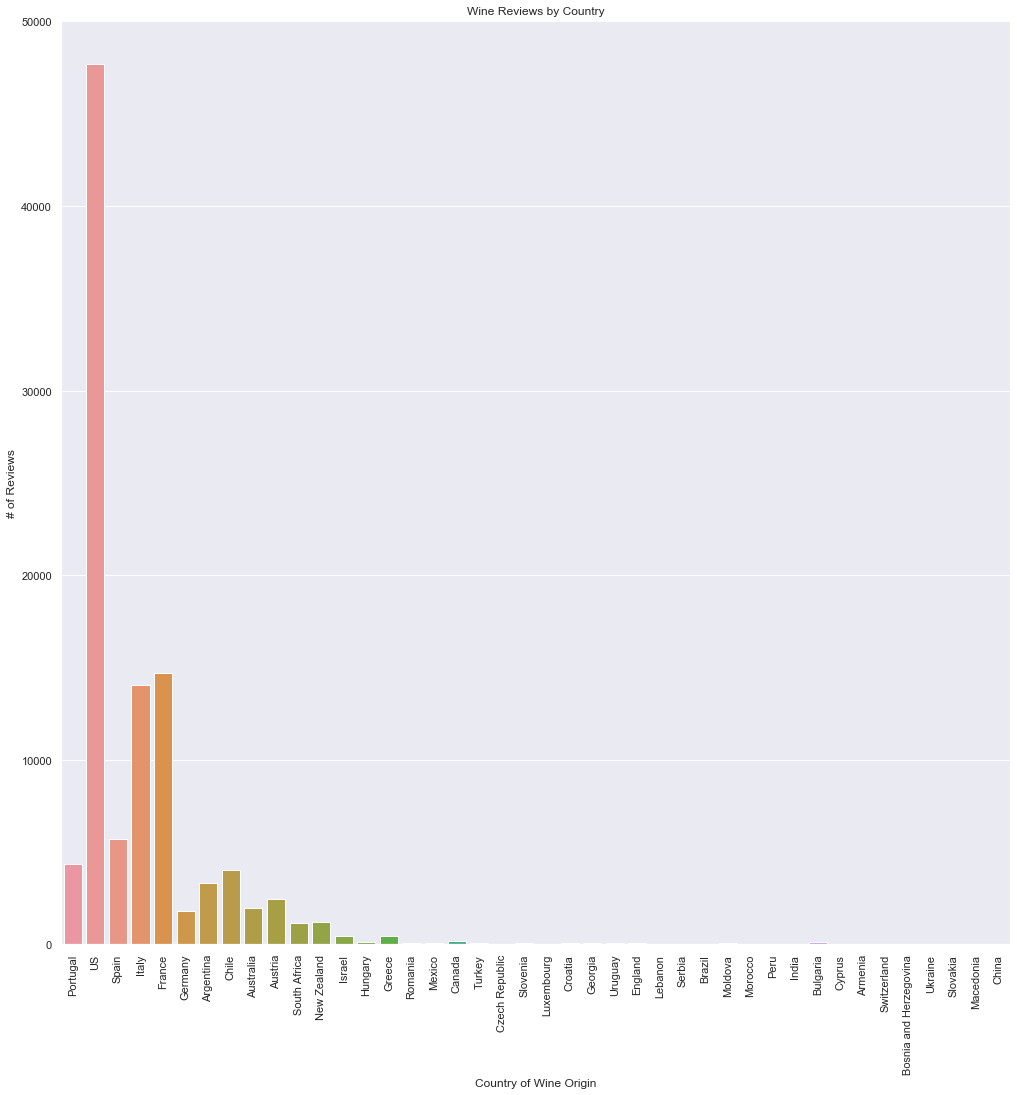

In [16]:
sns.countplot(x='country', data=adj_cwd)
plt.xticks(rotation=90)
plt.title('Wine Reviews by Country')
plt.ylabel("# of Reviews")
plt.xlabel("Country of Wine Origin")
plt.savefig("Reviewed_Countries_Seaborn_Barchart.png")

The total number of unique state/provinces is 421
The top 20 most reviewed states/provinces are: 
[province
California            31410
Washington             7689
Oregon                 4715
Tuscany                4054
Bordeaux               3445
Northern Spain         3274
Mendoza Province       2865
New York               2438
Piedmont               2325
Burgundy               2145
Veneto                 1975
Alsace                 1895
Northeastern Italy     1790
Loire Valley           1436
Sicily & Sardinia      1387
Southwest France       1193
South Australia        1140
Southern Italy         1016
Provence               1007
Central Italy           994
Name: points, dtype: int64]


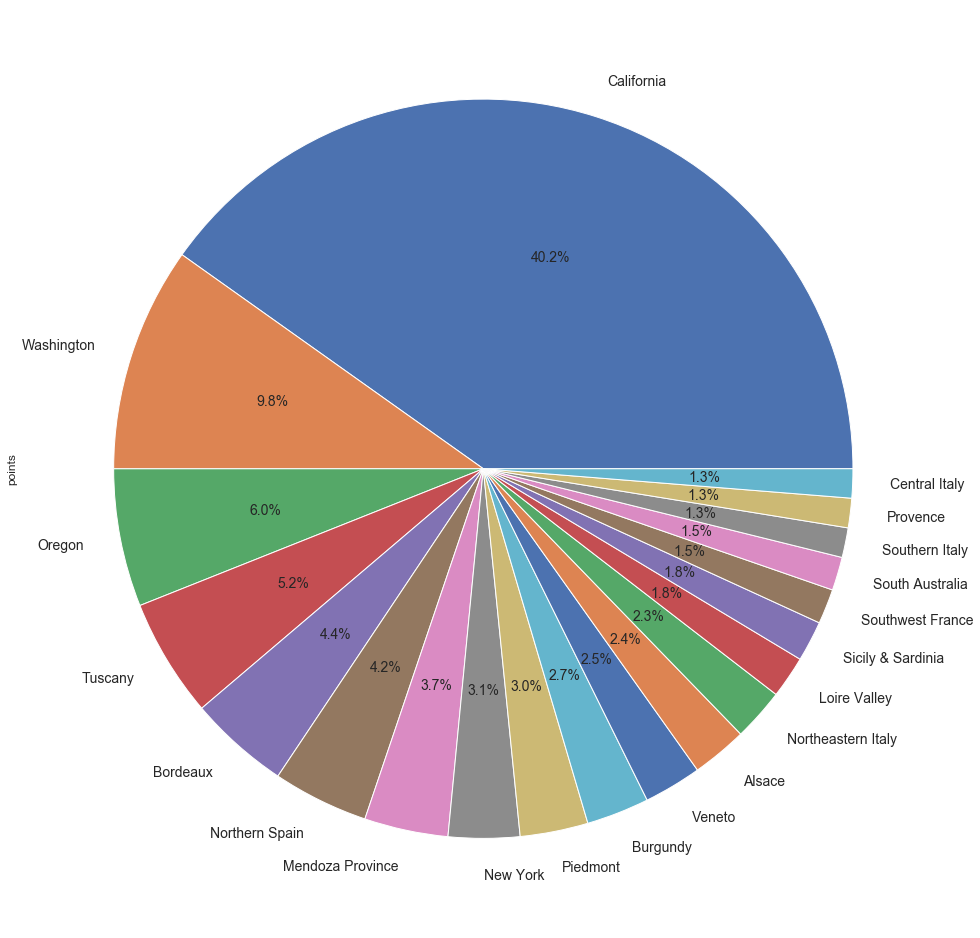

In [17]:
# See percentage of review by province/state for top 20
cwd_prov = adj_cwd.groupby('province')
cwd_prov_count = cwd_prov['points'].count()

print(f'The total number of unique state/provinces is {len(cwd_prov_count.index)}')
print('The top 20 most reviewed states/provinces are: ')
print([cwd_prov_count.sort_values(ascending=False).head(20)])

# Create pie plot of top 20 types by count of all wines
t20_cwd_prov_count = cwd_prov_count.sort_values(ascending=False).head(20)
t20_cwd_prov_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})
plt.savefig("Reviewed_Province_Pie_Chart.png")

In [18]:
# Create df for CA wines
clean_ca_wines = adj_cwd.loc[adj_cwd['province'] == "California"]
clean_ca_wines.head()

,country,points,price,province,title,variety,winery,new_wine_metric
10,US,87,19.0,California,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,2.375
12,US,87,34.0,California,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini,4.250
14,US,87,12.0,California,Mirassou 2012 Chardonnay (Central Coast),Chardonnay,Mirassou,1.500
23,US,87,22.0,California,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi,2.750
25,US,87,69.0,California,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,8.625


In [19]:
# create df for all wines
clean_gbl_wines = adj_cwd.copy()
clean_gbl_wines.head()

,country,points,price,province,title,variety,winery,new_wine_metric
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1.875
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,1.750
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,1.625
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,8.125
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,1.875


In [20]:
# create df for all wines excluding CA wines
clean_gbl_wines_noca = clean_gbl_wines.loc[clean_gbl_wines['province'] != "California"]
clean_gbl_wines_noca.head()

,country,points,price,province,title,variety,winery,new_wine_metric
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1.875
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,1.750
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,1.625
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,8.125
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,1.875


[variety
Pinot Noir                  6140
Chardonnay                  4720
Cabernet Sauvignon          4027
Zinfandel                   2446
Syrah                       1705
Sauvignon Blanc             1669
Red Blend                   1566
Merlot                      1265
Petite Sirah                 628
Bordeaux-style Red Blend     585
Sparkling Blend              485
Rosé                         461
Rhône-style Red Blend        443
Viognier                     394
Grenache                     344
White Blend                  333
Cabernet Franc               301
Pinot Grigio                 268
Riesling                     239
Sangiovese                   235
Name: title, dtype: int64]

There are 189 varietal types of wine reviewed from Califonrina

This is a breakdown of the top 20 varieties by count of reviews


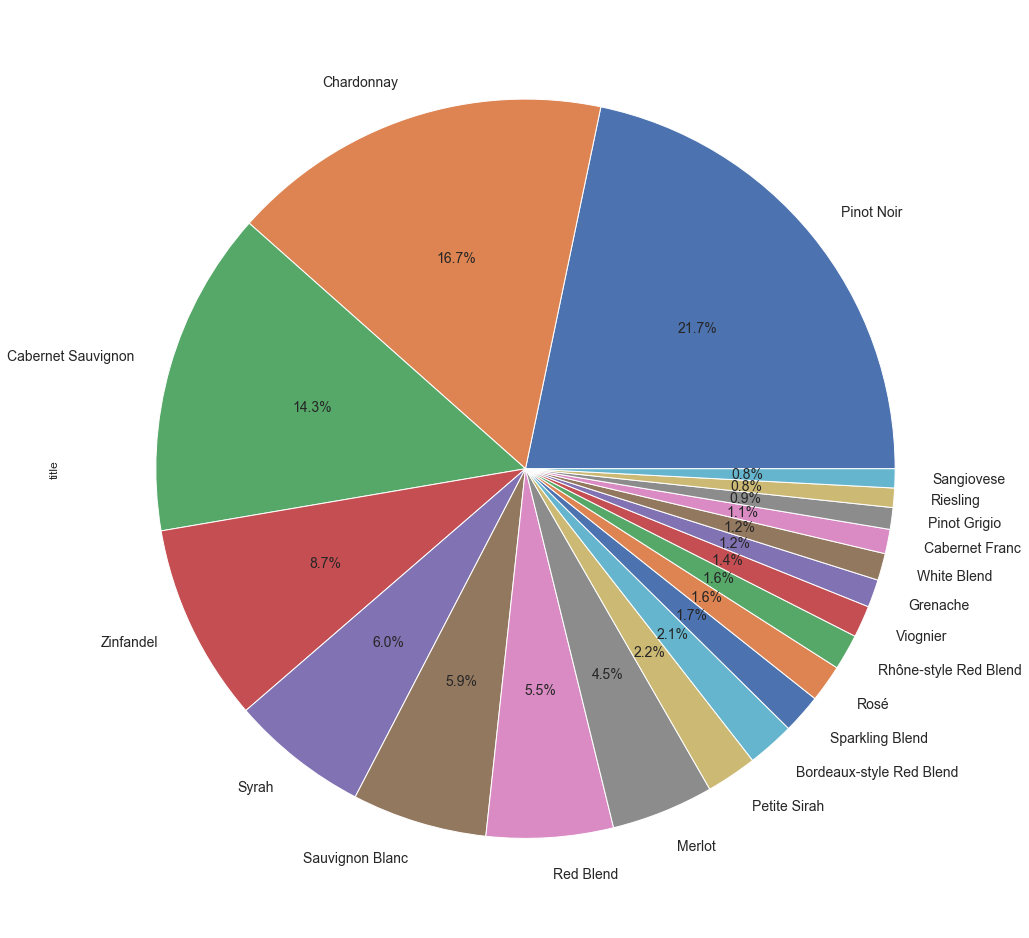

In [21]:
#ordered list of types and counts of CA wines
ca_varietal = clean_ca_wines.groupby('variety')
ca_type_count = ca_varietal['title'].count()
print([ca_type_count.sort_values(ascending=False).head(20)])
print()
print(f'There are {len(ca_type_count.index)} varietal types of wine reviewed from Califonrina')
print()
# Create pie plot of top 20 types by count of CA wines
print('This is a breakdown of the top 20 varieties by count of reviews')
t20_ca_type_count = ca_type_count.sort_values(ascending=False).head(20)
t20_ca_type_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})
plt.savefig("Reviewed_Variety_CA.png")

[variety
Pinot Noir                  10937
Chardonnay                   9771
Cabernet Sauvignon           7341
Red Blend                    7292
Bordeaux-style Red Blend     4408
Sauvignon Blanc              4392
Riesling                     4380
Syrah                        3581
Rosé                         2939
Merlot                       2774
Zinfandel                    2518
Malbec                       2270
White Blend                  1971
Portuguese Red               1959
Sangiovese                   1887
Sparkling Blend              1801
Nebbiolo                     1650
Tempranillo                  1558
Pinot Gris                   1247
Rhône-style Red Blend        1236
Name: title, dtype: int64]

There are 686 varietal types of wine reviewed from All over the world

This is a breakdown of the top 20 by count of reviews


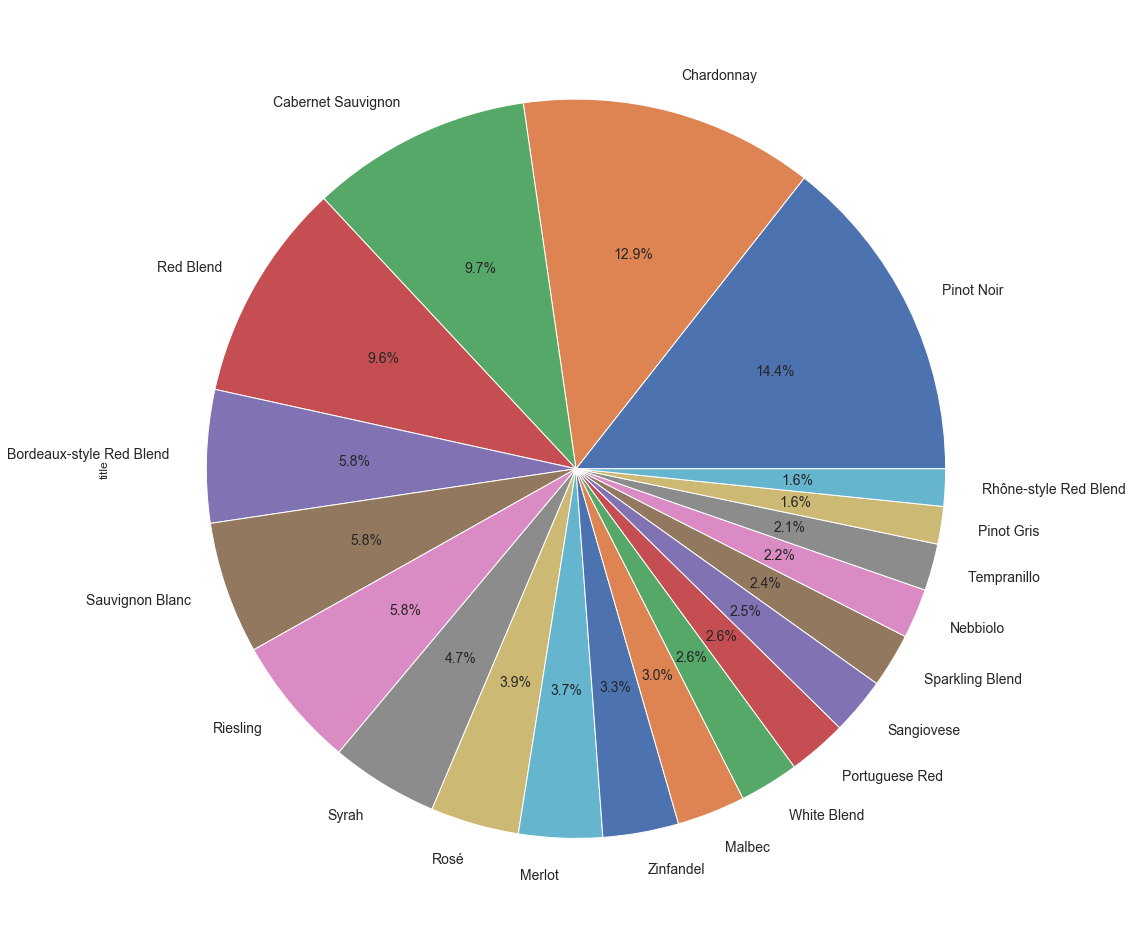

In [22]:
#ordered list of types and counts of Global wines including CA
gbl_varietal = clean_gbl_wines.groupby('variety')
gbl_type_count = gbl_varietal['title'].count()
print([gbl_type_count.sort_values(ascending=False).head(20)])
print()
print(f'There are {len(gbl_type_count.index)} varietal types of wine reviewed from All over the world')
print()
# Create pie plot of top 20 types by count of Global wines including CA
print('This is a breakdown of the top 20 by count of reviews')
t20_gbl_type_count = gbl_type_count.sort_values(ascending=False).head(20)
t20_gbl_type_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})
plt.savefig("Reviewed_Variety_GBL.png")

[variety
Red Blend                   5726
Chardonnay                  5051
Pinot Noir                  4797
Riesling                    4141
Bordeaux-style Red Blend    3823
Cabernet Sauvignon          3314
Sauvignon Blanc             2723
Rosé                        2478
Malbec                      2096
Portuguese Red              1959
Syrah                       1876
Sangiovese                  1652
White Blend                 1638
Nebbiolo                    1622
Merlot                      1509
Tempranillo                 1436
Sparkling Blend             1316
Pinot Gris                  1074
Grüner Veltliner             983
Portuguese White             904
Name: title, dtype: int64]

There are 666 varietal types of wine reviewed from everywhere else besides Califonrina

This is a breakdown of the top 20 by count of reviews


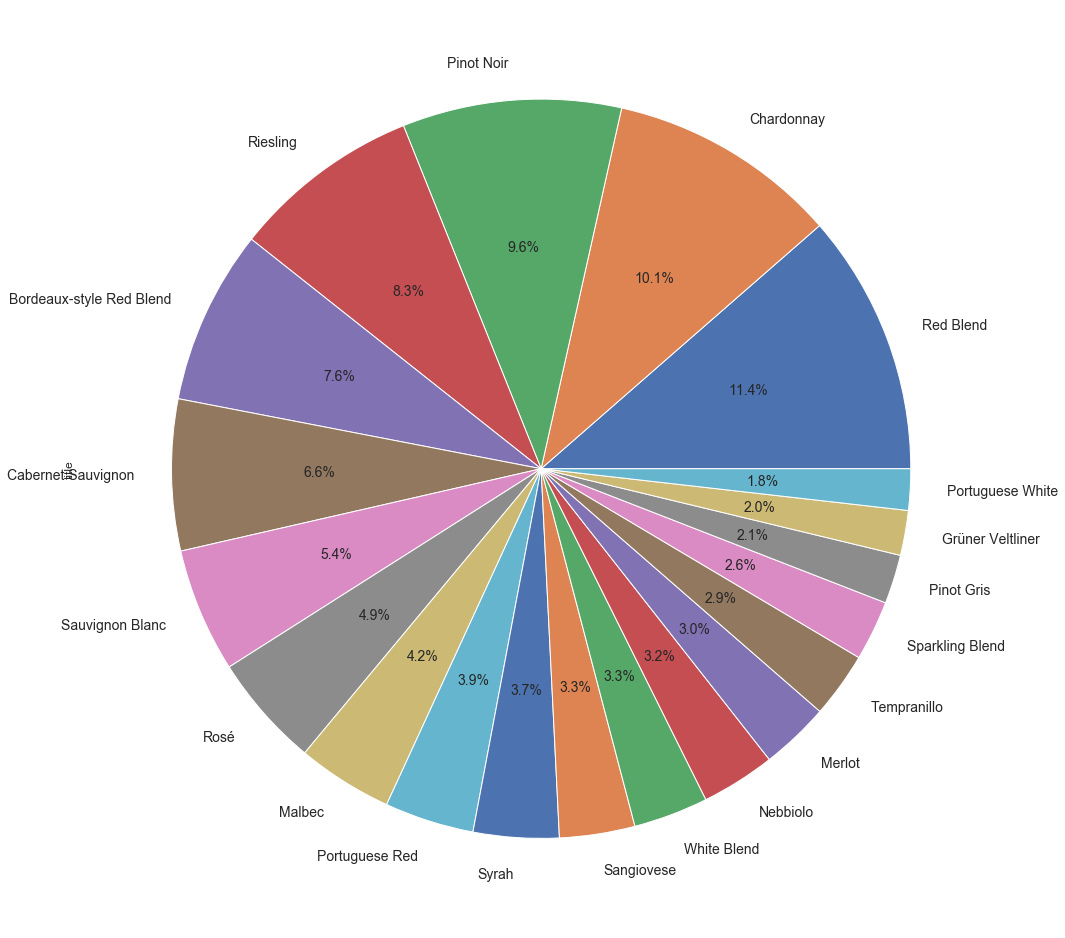

In [23]:
#ordered list of types and counts of Global wines without CA
noca_gbl_varietal = clean_gbl_wines_noca.groupby('variety')
noca_gbl_type_count = noca_gbl_varietal['title'].count()
print([noca_gbl_type_count.sort_values(ascending=False).head(20)])
print()
print(f'There are {len(noca_gbl_type_count.index)} varietal types of wine reviewed from everywhere else besides Califonrina')
print()
# Create pie plot of top 20 types by count of Global wines without CA
print('This is a breakdown of the top 20 by count of reviews')
t20_noca_gbl_type_count = noca_gbl_type_count.sort_values(ascending=False).head(20)
t20_noca_gbl_type_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})
plt.savefig("Reviewed_Variety_NONCA.png")

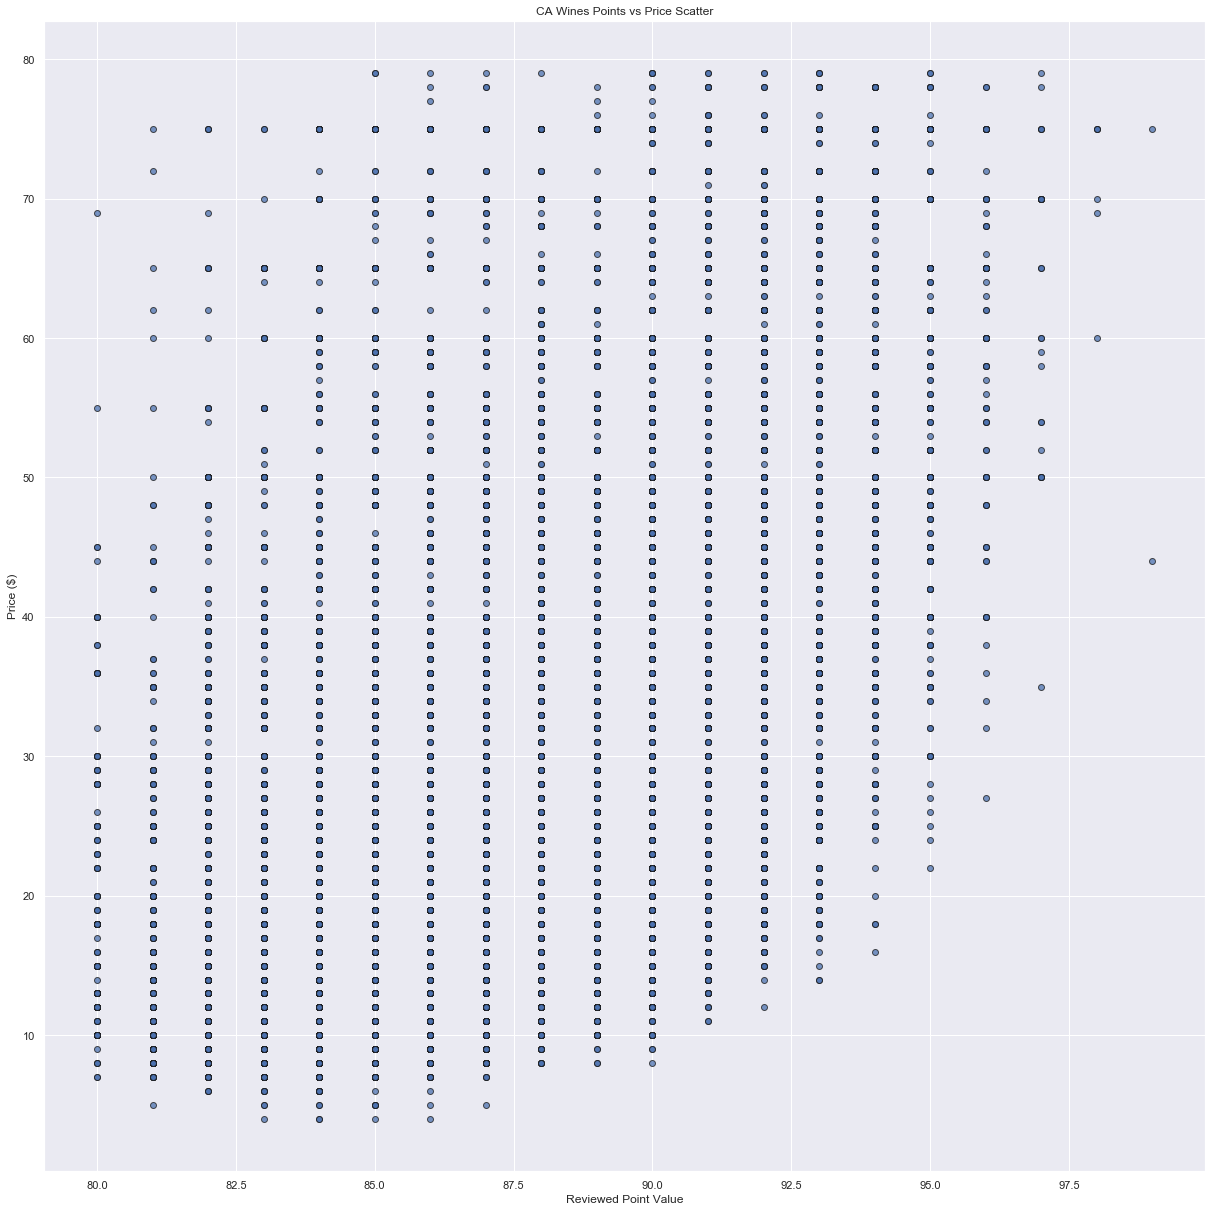

In [24]:
# points vs price
plt.figure(figsize=(17, 17))
plt.scatter(clean_ca_wines['points'], clean_ca_wines['price'], alpha=.75, edgecolors="k")
# x,y required , alpha sets opacity, edgecolors help datapoint stand out https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.title(f"CA Wines Points vs Price Scatter")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
# tight_layout. This module provides routines to adjust subplot params so that subplots are nicely fit in the figure. https://matplotlib.org/api/tight_layout_api.html
plt.savefig("CA_Scatterplot.png")
plt.show()

The correlation coefficient between Review Points and Price is 0.51 for CA Wines


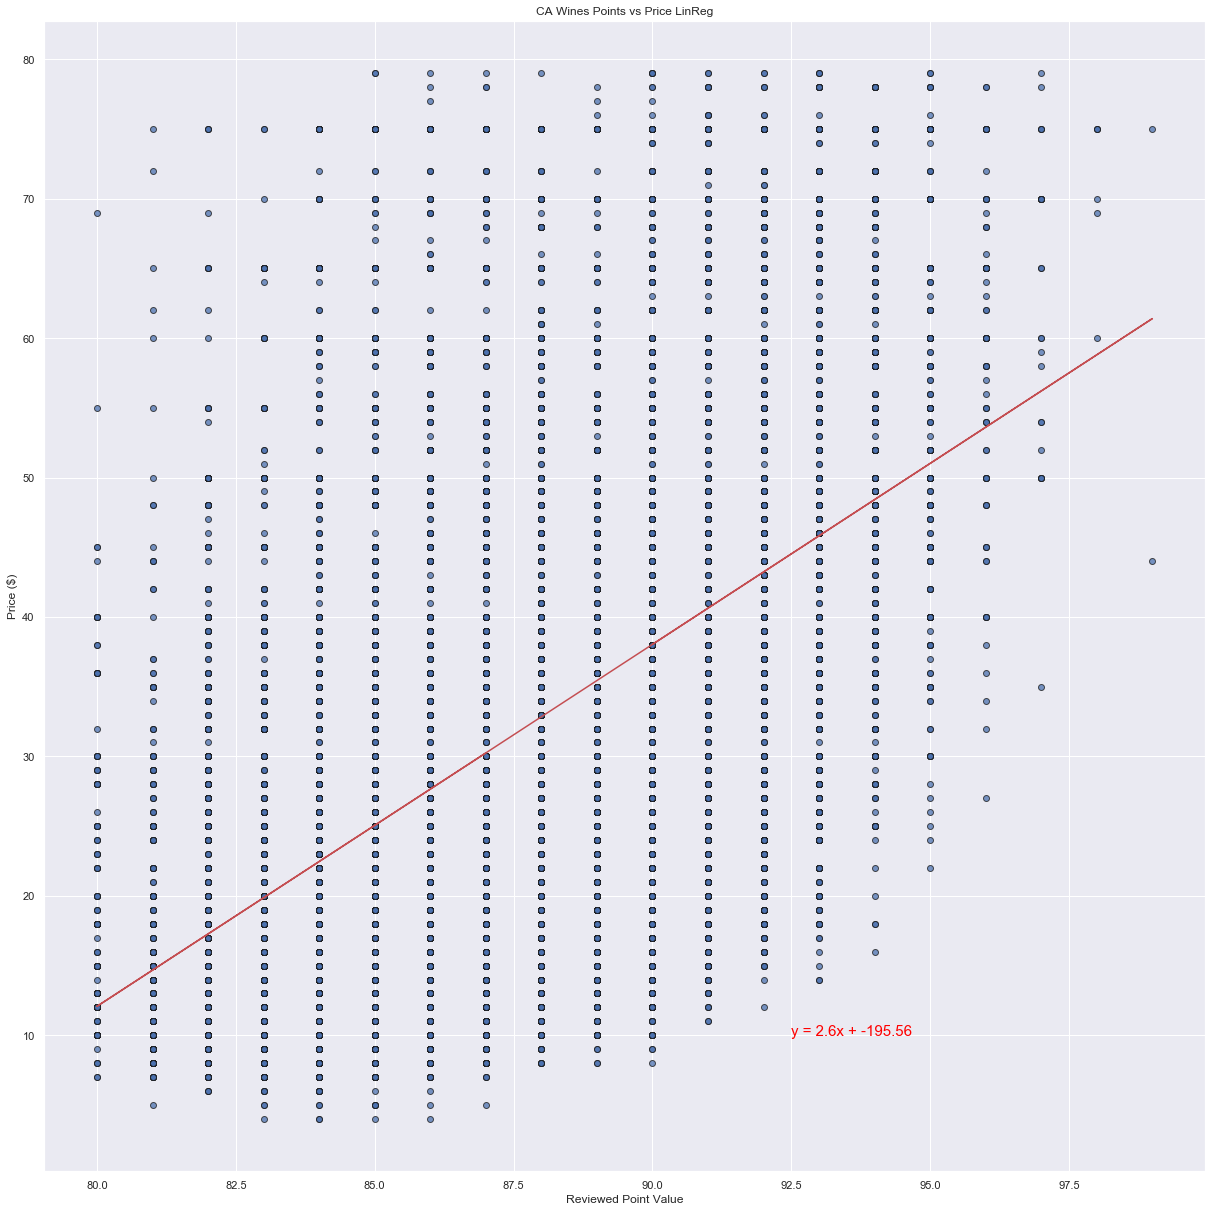

In [25]:
x_values = clean_ca_wines['points'].astype(float)
y_values = clean_ca_wines['price'].astype(float)

# Calculate Pearson r value
print(f"The correlation coefficient between Review Points and Price is {round(stats.pearsonr(x_values,y_values)[0],2)} for CA Wines")

# Calculate line for plot
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Create plot and labels

plt.figure(figsize=(17, 17))
plt.title(f"CA Wines Points vs Price LinReg")
plt.scatter(x_values,y_values, alpha=.75, edgecolors="k") 
# x,y required , alpha sets opacity, edgecolors help datapoint stand out https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(92.5,10),fontsize=15,color="red")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
plt.savefig("CA_Scatterplot_Linreg.png")
plt.show()

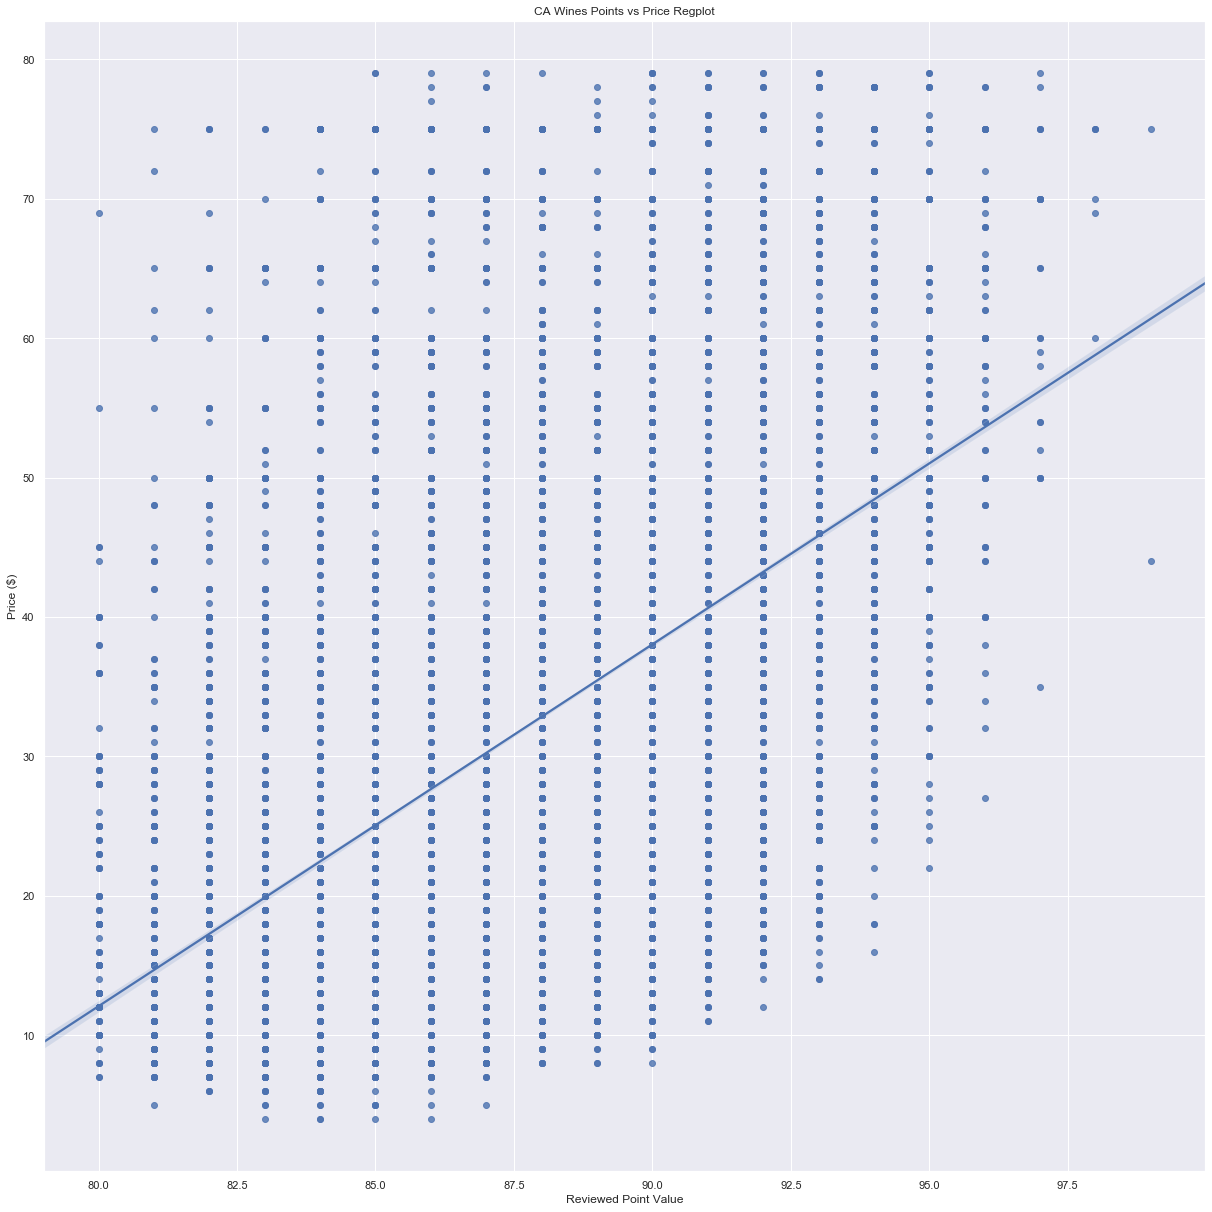

In [26]:
#seaborn scatterplot
plt.figure(figsize=(17, 17))
sns.regplot(x='points', y='price', data=clean_ca_wines)
plt.title(f"CA Wines Points vs Price Regplot")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
plt.savefig("CA_Regplot.png")
plt.show()

In [27]:
#sns.swarmplot(x='points', y='price', data=clean_ca_wines)
#plt.savefig("CA_swarmplot.png")

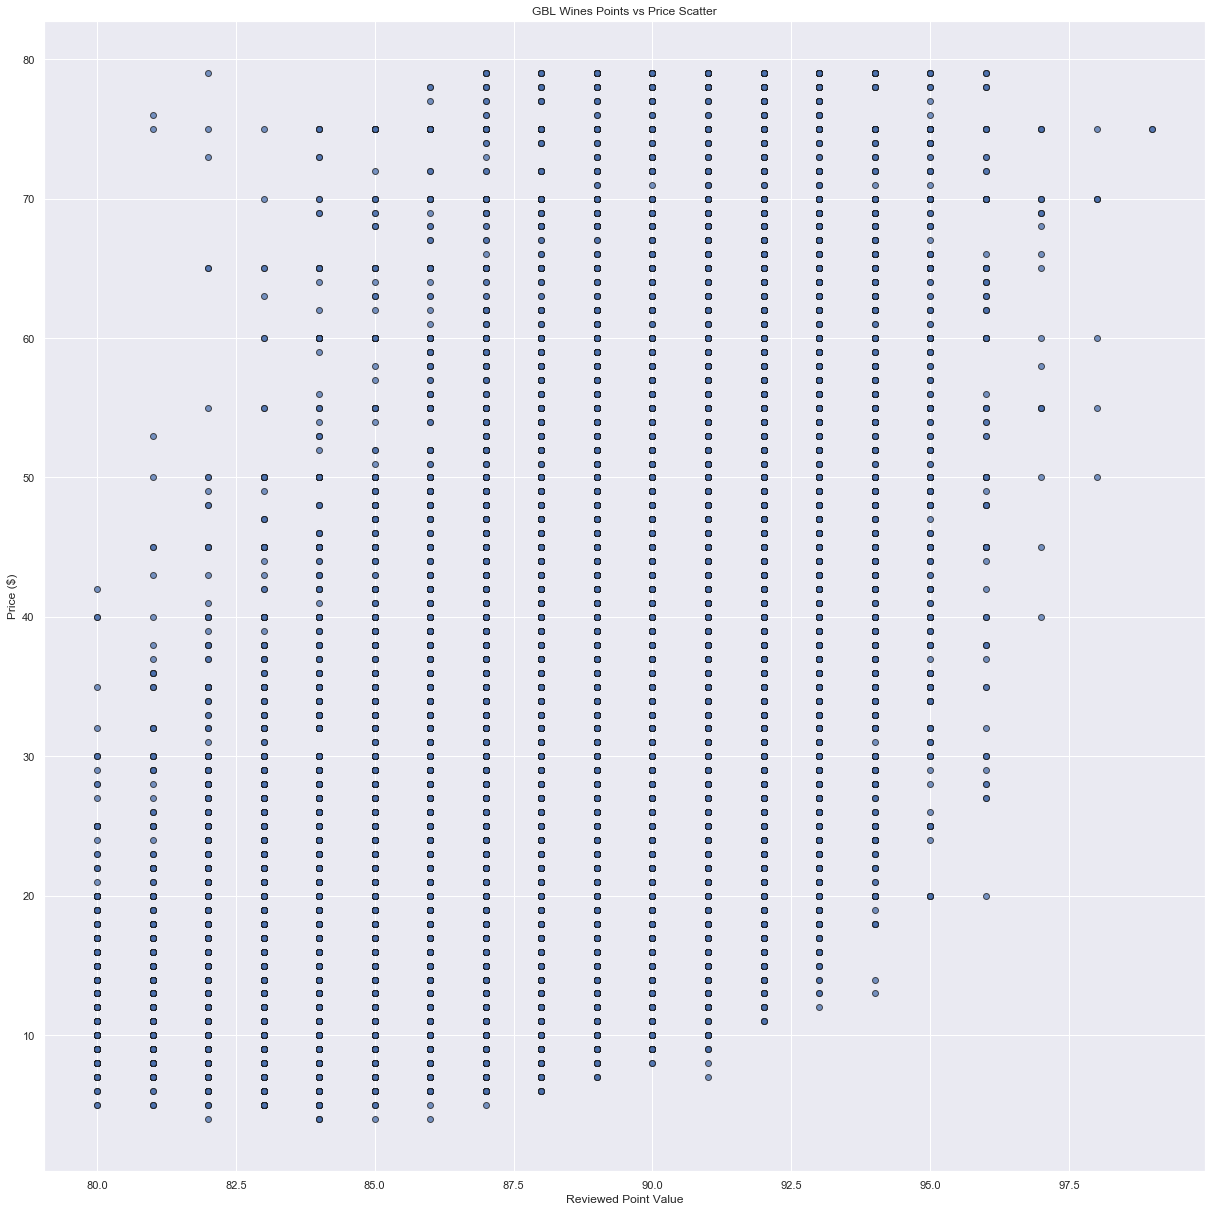

In [28]:
# GBL no CA points vs price
plt.figure(figsize=(17, 17))
plt.scatter(clean_gbl_wines_noca['points'], clean_gbl_wines_noca['price'], alpha=.75, edgecolors="k")
# x,y required , alpha sets opacity, edgecolors help datapoint stand out https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.title(f"GBL Wines Points vs Price Scatter")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
# tight_layout. This module provides routines to adjust subplot params so that subplots are nicely fit in the figure. https://matplotlib.org/api/tight_layout_api.html
plt.savefig("NonCA_Scatterplot.png")
plt.show()

The correlation coefficient between Review Points and Price is 0.56 for GBL Wines not from CA


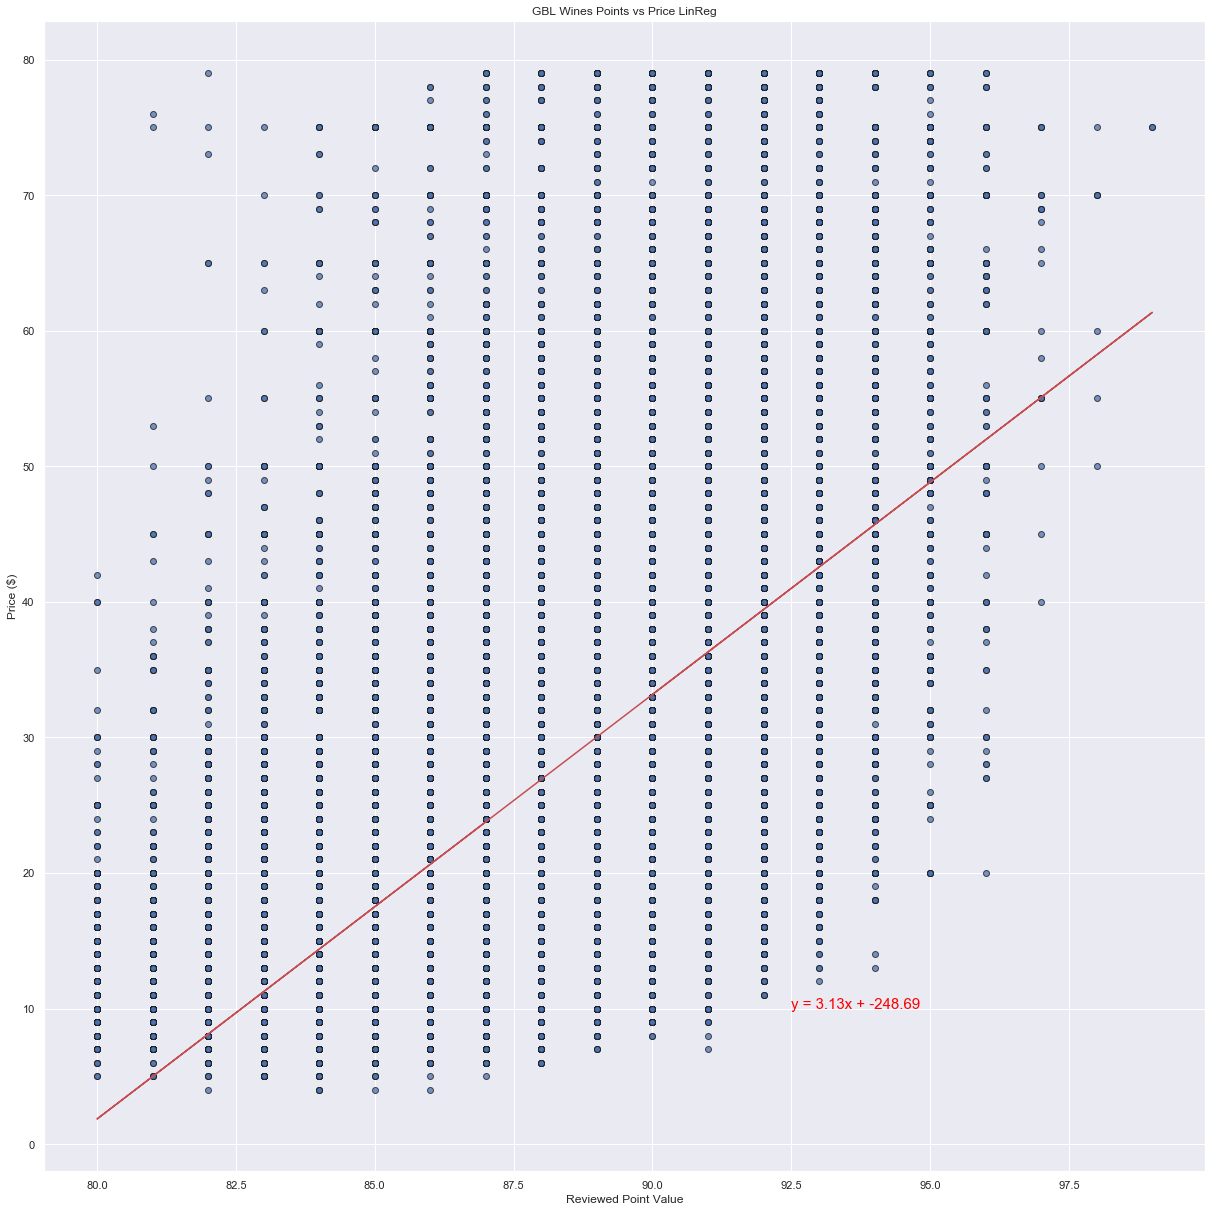

In [29]:
x_values = clean_gbl_wines_noca['points'].astype(float)
y_values = clean_gbl_wines_noca['price'].astype(float)

# Calculate Pearson r value
print(f"The correlation coefficient between Review Points and Price is {round(stats.pearsonr(x_values,y_values)[0],2)} for GBL Wines not from CA")

# Calculate line for plot
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Create plot and labels

plt.figure(figsize=(17, 17))
plt.title(f"GBL Wines Points vs Price LinReg")
plt.scatter(x_values,y_values, alpha=.75, edgecolors="k") 
# x,y required , alpha sets opacity, edgecolors help datapoint stand out https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(92.5,10),fontsize=15,color="red")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
plt.savefig("NonCA_Scatterplot_Linreg.png")
plt.show()

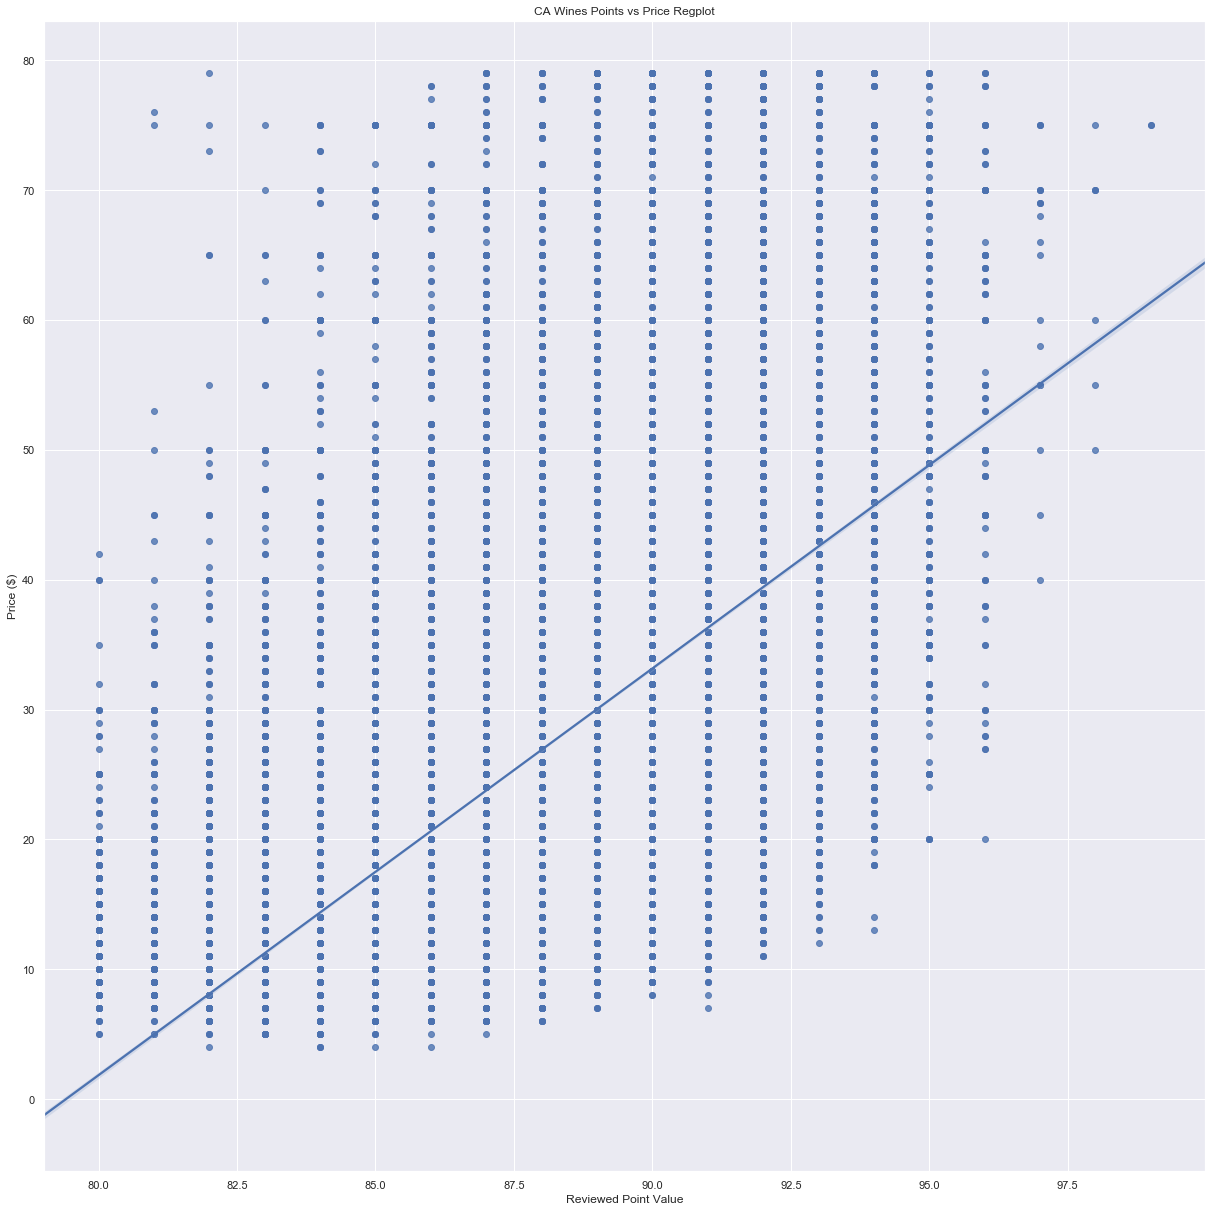

In [30]:
#seaborn scatterplot
plt.figure(figsize=(17, 17))
sns.regplot(x='points', y='price', data=clean_gbl_wines_noca)
plt.title(f"CA Wines Points vs Price Regplot")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout()
plt.savefig("NonCA_regplot.png")
plt.show()

In [31]:
#sns.swarmplot(x='points', y='price', data=clean_gbl_wines_noca)
#plt.savefig("NonCA_swarmplot.png")

In [32]:
# Good Value would be low on price and high on rating.
# look at IQR for price
adj_cwd_price_iqr = adj_cwd['price']
adj_cwd_quartiles = round(adj_cwd_price_iqr.quantile([.25,.5,.75]),2)
adj_cwd_lowerq = round(adj_cwd_quartiles[0.25],2)
#adj_cwd_upperq = round(adj_cwd_quartiles[0.75],2)
#adj_cwd_iqr = round(adj_cwd_upperq-adj_cwd_lowerq,2)
#print(adj_cwd_lowerq)

adj_cwd_pts_iqr = adj_cwd['points']
adj_cwd_pts_quartiles = round(adj_cwd_pts_iqr.quantile([.25,.5,.75]),2)
#adj_cwd_pts_lowerq = round(adj_cwd_pts_quartiles[0.25],2)
adj_cwd_pts_upperq = round(adj_cwd_pts_quartiles[0.75],2)
#adj_cwd_pts_iqr = round(adj_cwd_pts_upperq-adj_cwd_pts_lowerq,2)
#print(adj_cwd_pts_upperq)

good_value_wines = clean_gbl_wines.loc[(clean_gbl_wines['price'] < [adj_cwd_lowerq][0]) & (clean_gbl_wines['points'] > [adj_cwd_pts_upperq][0])]
good_value_wines

,country,points,price,province,title,variety,winery,new_wine_metric
127,France,91,13.0,Alsace,Pierre Sparr 2008 Alsace One White (Alsace),White Blend,Pierre Sparr,1.083333
156,Germany,91,14.0,Mosel,Carl Graff 2014 Graacher Himmelreich Spätlese ...,Riesling,Carl Graff,1.166667
1506,France,92,15.0,Southwest France,Château d'Aydie 2010 Madiran Laplace Tannat (M...,Tannat,Château d'Aydie,1.153846
2866,Portugal,91,15.0,Tejo,Quinta do Casal Branco 2011 Falcoaria Fernão P...,Fernão Pires,Quinta do Casal Branco,1.250000
3017,Austria,92,13.0,Burgenland,Scheiblhofer 2010 Andau Zweigelt (Burgenland),Zweigelt,Scheiblhofer,1.000000
...,...,...,...,...,...,...,...,...
126797,Portugal,92,15.0,Beira Interior,Companhia das Quintas 2005 Quinta do Cardo Sel...,Portuguese Red,Companhia das Quintas,1.153846
127554,US,91,13.0,California,Cameron Hughes 2007 Lot 175 Merlot (Napa Valley),Merlot,Cameron Hughes,1.083333
128010,US,92,11.0,Washington,Pacific Rim 2009 Riesling (Columbia Valley (WA)),Riesling,Pacific Rim,0.846154
128951,Israel,91,15.0,Galilee,Golan Heights Winery 2012 Gilgal Cabernet Merl...,Cabernet Merlot,Golan Heights Winery,1.250000


The sorted list of states/provinces with the most reviews in the category of good value wines:
province
California              43
Washington              35
Bordeaux                23
Southwest France        20
Douro                   15
Tejo                    14
Oregon                  14
Loire Valley             9
Rhône Valley             9
Bairrada                 8
Alentejano               7
Lisboa                   6
Burgenland               6
Beaujolais               5
Niederösterreich         5
Northeastern Italy       5
Kremstal                 5
Kamptal                  5
Carnuntum                4
Galilee                  4
Marlborough              4
Dão                      4
Tuscany                  4
Andalucia                4
Rapel Valley             3
Alentejo                 3
Beiras                   3
Mendoza Province         3
Alsace                   3
Vinho Verde              2
Wachau                   2
Wagram                   2
Central Italy            2
Victo

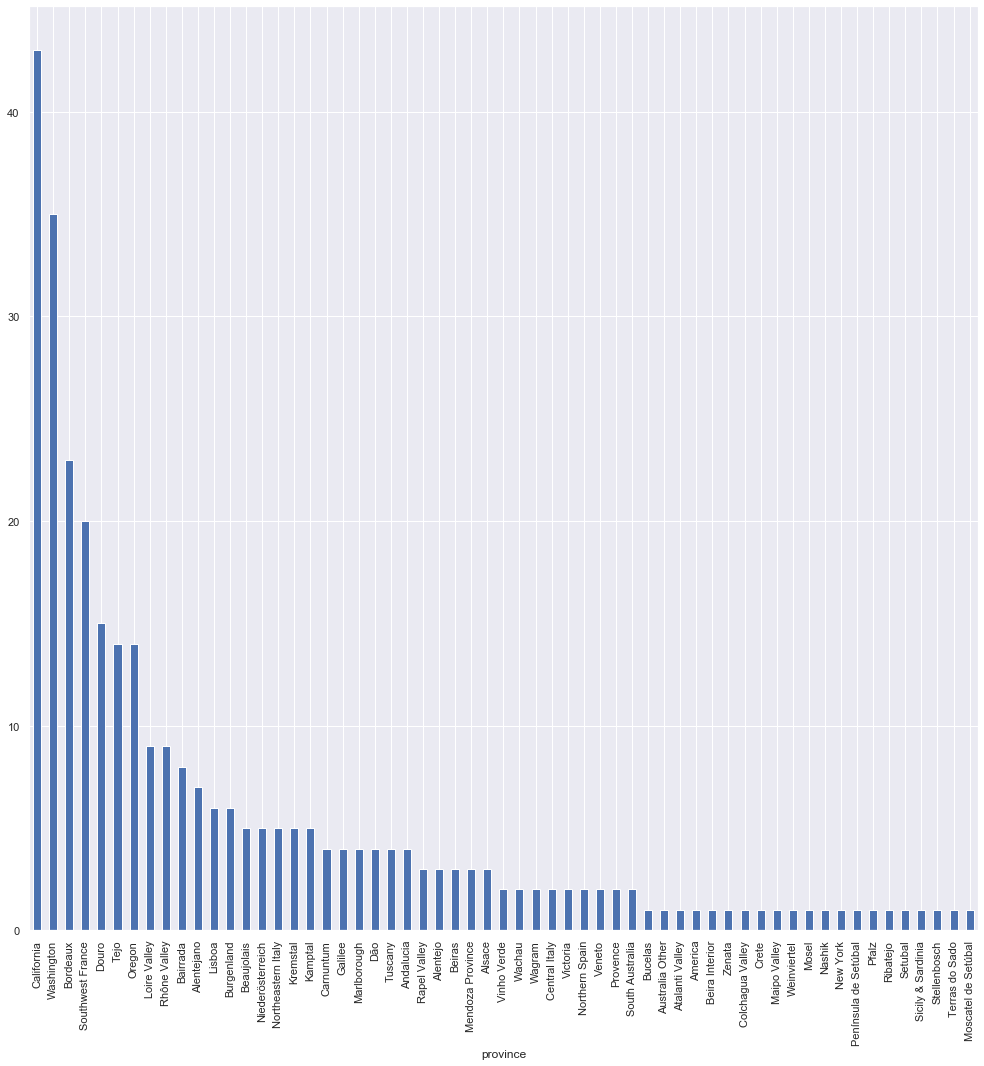

In [33]:
good_value_wines_prov = good_value_wines.groupby('province')
gvw_prov = good_value_wines_prov['title'].count()
print(f'The sorted list of states/provinces with the most reviews in the category of good value wines:')
t20_gvw_prov = gvw_prov.sort_values(ascending=False)
print(t20_gvw_prov)
t20_gvw_prov.plot.bar(figsize=(17,17))
plt.savefig("Good_Value_Prov_Barplot.png")

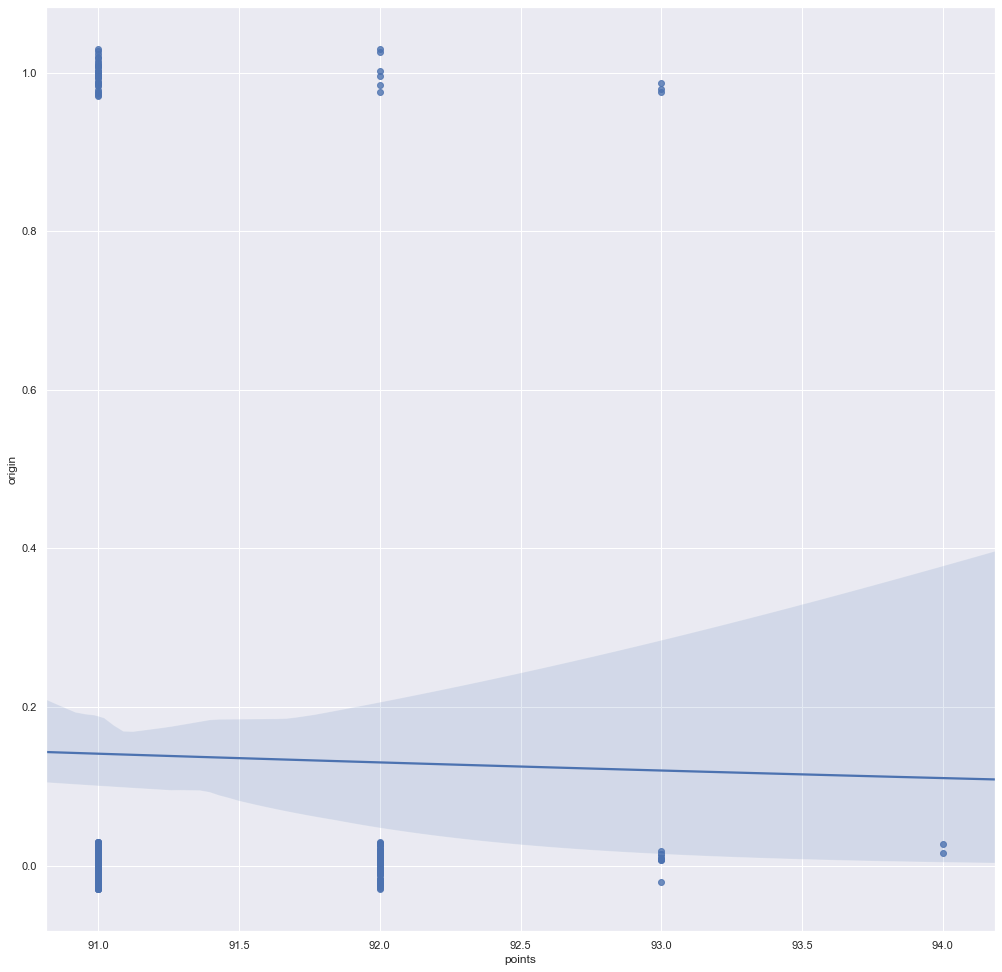

In [37]:

log_plt_data = good_value_wines[['points','province']]
log_plt_data.loc[log_plt_data['province'] == 'California', 'origin'] = 1
log_plt_data.loc[log_plt_data['province'] != 'California', 'origin'] = 0
sns.regplot(x="points", y="origin", data=log_plt_data,
                 logistic=True, n_boot=50, y_jitter=.03)


In [38]:
# top 10 province by avg price
# See percentage of review by province/state for top 20
### Using cwd_prov = CWD.groupby('province') from above

cwd_prov_mean = cwd_prov['price'].mean().round(2)

print([cwd_prov_mean])
print()
print('The top 10 most expensive to least expensive provinces/states reviewed were:')
print([cwd_prov_mean.sort_values(ascending=False).head(10)])
print()
print(f'There were {len(cwd_prov_mean.index)} provinces/states reviewed.')

[province
Achaia                       23.00
Aconcagua Costa              20.60
Aconcagua Valley             23.12
Aegean                       29.56
Agioritikos                  23.50
                             ...  
Zenata                       16.71
Österreichischer Perlwein    16.75
Österreichischer Sekt        27.84
Štajerska                    17.44
Župa                         28.40
Name: price, Length: 421, dtype: float64]

The top 10 most expensive to least expensive provinces/states reviewed were:
[province
Haut-Judeé                   66.25
Middle and South Dalmatia    65.00
Südburgenland                57.00
Waitaki Valley               55.00
Champagne                    53.34
Jerusalem Hills              52.50
England                      49.21
Golan Heights                46.67
Ahr                          46.00
Madeira                      45.83
Name: price, dtype: float64]

There were 421 provinces/states reviewed.


In [40]:
# top 20 most reviewed wineries by avg point - count of reviews and then avg reviews
winery_groups = clean_gbl_wines.groupby('winery')

print(f'The number of unique wineries reviewed is {len(winery_groups)}')
print()
winery_groups_count = winery_groups['points'].count()
print('The most frequently reviewed wineries are:')
print([winery_groups_count.sort_values(ascending=False).head(20)])
print()
print()
winery_groups_avg_points = winery_groups['points'].mean()
print([winery_groups_avg_points.sort_values(ascending=False).head(20)])
print()
print()
winery_groups_avg_price = winery_groups['price'].mean().round(2)
print([winery_groups_avg_price.sort_values(ascending=False).head(20)])
print()
print()
winery_merged_data = pd.merge(winery_groups_count,winery_groups_avg_points, on="winery", how="inner")
winery_merged_data = pd.merge(winery_merged_data,winery_groups_avg_price, on="winery", how="inner")
winery_merged_data.columns = ['Review Count','Avg Review','Avg Price']
print([winery_merged_data.sort_values(by=['Review Count'],ascending=False).head(50)])

The number of unique wineries reviewed is 15532

The most frequently reviewed wineries are:
[winery
Wines & Winemakers       199
Testarossa               196
DFJ Vinhos               194
Williams Selyem          182
Chateau Ste. Michelle    170
Columbia Crest           145
Concha y Toro            140
Gary Farrell             118
Kendall-Jackson          114
Siduri                   113
Georges Duboeuf          112
Trapiche                 106
Undurraga                103
Lynmar                   103
Santa Ema                101
Robert Mondavi            99
Maryhill                  97
Foxen                     96
Kenwood                   94
Montes                    94
Name: points, dtype: int64]


[winery
Lewis                          96.00
D'Alfonso-Curran               96.00
Schloss Schönborn              95.00
Château Pichon Longueville     95.00
Château Doisy-Daëne            95.00
Aleksander                     95.00
Château Guiraud                95.00
Schiavenza             

[    country  points  price        province  \
1  Portugal      87   15.0           Douro   
2        US      87   14.0          Oregon   
3        US      87   13.0        Michigan   
4        US      87   65.0          Oregon   
5     Spain      87   15.0  Northern Spain   

                                               title             variety  \
1      Quinta dos Avidagos 2011 Avidagos Red (Douro)      Portuguese Red   
2      Rainstorm 2013 Pinot Gris (Willamette Valley)          Pinot Gris   
3  St. Julian 2013 Reserve Late Harvest Riesling ...            Riesling   
4  Sweet Cheeks 2012 Vintner's Reserve Wild Child...          Pinot Noir   
5  Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...  Tempranillo-Merlot   

                winery  new_wine_metric  
1  Quinta dos Avidagos            1.875  
2            Rainstorm            1.750  
3           St. Julian            1.625  
4         Sweet Cheeks            8.125  
5               Tandem            1.875  ]


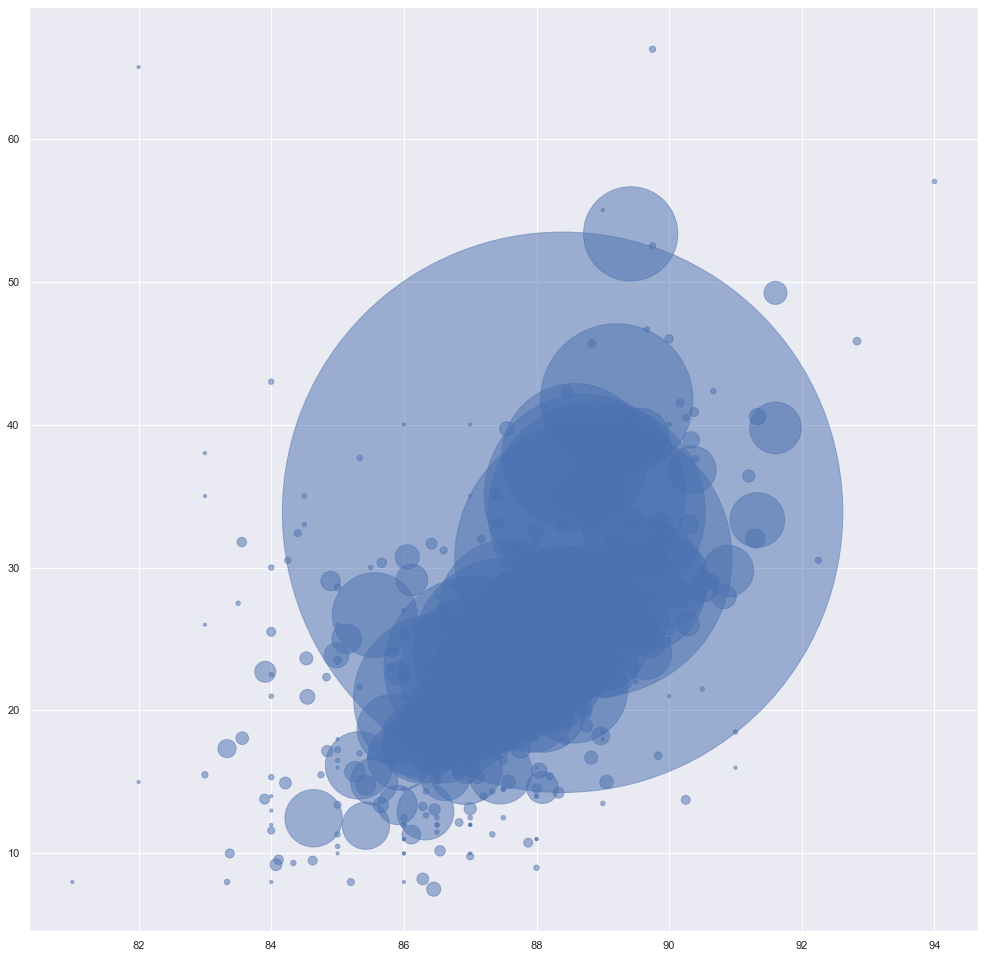

In [53]:
print([adj_cwd.head()])

bblplt_data = adj_cwd.groupby('province')

x=bblplt_data['points'].mean()
y=bblplt_data['price'].mean()
z=bblplt_data['title'].count()

plt.scatter(x,y, s=z*10, alpha=0.5)

In [ ]:
cal_wine_count = clean_ca_wines['price'].count()
noncal_wine_count = clean_gbl_wines_noca['price'].count()


# look at IQR for price
cal_price_iqr = clean_ca_wines['price']
cal_quartiles = round(cal_price_iqr.quantile([.25,.5,.75]),2)
cal_lowerq = round(cal_quartiles[0.25],2)
cal_upperq = round(cal_quartiles[0.75],2)
cal_iqr = round(cal_upperq-cal_lowerq,2)

print('California IQR price Data:')
print(f"The lower quartile of price for Californian Wines is : {cal_lowerq}")
print(f"The upper quartile of price for Californian Wines is: {cal_upperq}")
print(f"The interquartile range of pricee for Californian Wines is: {cal_iqr}")
print(f"The the median of price for Californian Wines is: {cal_quartiles[0.5]} ")

cal_lower_bound = round(cal_lowerq - (1.5*cal_iqr),2)
cal_upper_bound = round(cal_upperq + (1.5*cal_iqr),2)

# print(f"Values below {cal_lower_bound} could be outliers.")

print(f"Values above {cal_upper_bound} could be outliers.")
#cal_lwr_otlr_count = clean_ca_wines.loc[clean_ca_wines['price'] <= {cal_lower_bound}]
cal_upr_otlr_count = clean_ca_wines['price'][clean_ca_wines['price'] >= 87].count()
cal_otlr_pct = (cal_upr_otlr_count/cal_wine_count)*100
print(f'Of the {cal_wine_count} Californian wines, There are {cal_upr_otlr_count} above the upper bounds or {cal_otlr_pct.round(2)}%')

noncal_price_iqr = clean_gbl_wines_noca['price']
noncal_quartiles = round(noncal_price_iqr.quantile([.25,.5,.75]),2)
noncal_lowerq = round(noncal_quartiles[0.25],2)
noncal_upperq = round(noncal_quartiles[0.75],2)
noncal_iqr = round(noncal_upperq-noncal_lowerq,2)

print()
print('Non Californian IQR price Data:')
print(f"The lower quartile of price for non Californian Wines is : {noncal_lowerq}")
print(f"The upper quartile of price for non Californian Wines is: {noncal_upperq}")
print(f"The interquartile range of pricee for non Californian Wines is: {noncal_iqr}")
print(f"The the median of price for non Californian Wines is: {noncal_quartiles[0.5]} ")

noncal_lower_bound = round(noncal_lowerq - (1.5*cal_iqr),2)
noncal_upper_bound = round(noncal_upperq + (1.5*cal_iqr),2)

# print(f"Values below {noncal_lower_bound} could be outliers.")

print(f"Values above {noncal_upper_bound} could be outliers.")

noncal_upr_otlr_count = clean_gbl_wines_noca['price'][clean_gbl_wines_noca['price'] >= 79].count()
noncal_otlr_pct = (noncal_upr_otlr_count/noncal_wine_count)*100
print(f'Of the {noncal_wine_count} NonCalifornian wines, There are {noncal_upr_otlr_count} NonCalifornian wines above the upper bounds or {noncal_otlr_pct.round(2)}%')

In [ ]:
#Eliminate outliers

bw_plt_data = []
bw_plt_data = clean_gbl_wines[['price','province']]
bw_plt_data.loc[bw_plt_data['province'] == 'California', 'origin'] = 'Californian'
bw_plt_data.loc[bw_plt_data['province'] != 'California', 'origin'] = 'NonCalifornian'
bw_plt_data

flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  linestyle='none')

bw_plt_data.boxplot(by="origin", flierprops=flierprops, figsize=(17,17))
#plt.set_title('Wine Origin Price')
#plt.set_ylabel('Price in USD')
plt.savefig("CA_v_NonCA_BW.png")
plt.show()

In [ ]:
# Run a ttest on points

# Isolate the data to compare
cal_reviews = adj_cwd.loc[adj_cwd['province'] == 'California']['points']
noncal_reviews = adj_cwd.loc[adj_cwd['province'] != 'California']['points']

# Note: Setting equal_var=False performs Welch's t-test which does 
# not assume equal population variance
stats.ttest_ind(cal_reviews, noncal_reviews, equal_var=False)

In [ ]:
# Run a ttest on price

# Isolate the data to compare
cal_price_reviews = adj_cwd.loc[adj_cwd['province'] == 'California']['price']
noncal_price_reviews = adj_cwd.loc[adj_cwd['province'] != 'California']['price']

# Note: Setting equal_var=False performs Welch's t-test which does 
# not assume equal population variance
stats.ttest_ind(cal_price_reviews, noncal_price_reviews, equal_var=False)

In [ ]:
# ANOVA Test

# Perform the ANOVA
stats.f_oneway(cal_reviews, noncal_reviews)

In [ ]:
# CHI Squared Analysis

chi_cal_nwm = adj_cwd.loc[adj_cwd['province'] == 'California']['new_wine_metric'].mean()
chi_noncal_nwm = adj_cwd.loc[adj_cwd['province'] != 'California']['new_wine_metric'].mean()

observed = pd.Series([[chi_cal_nwm][0],[chi_noncal_nwm][0]], index=["California", "NonCalifornia"])

wine_chi = pd.DataFrame([observed]).T

# Create a data frame
wine_chi[1] = CWD['new_wine_metric'].mean()

# Rename columns
wine_chi.columns = ["observed", "expected"]

# View the data frame
wine_chi

In [ ]:
# The degree of freedom is either California or Non California so DoF (2-1 = 1)
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.

critical_value = stats.chi2.ppf(q = 0.95, df = 1)

# The critical value
print(critical_value)

# Run the chi square test with stats.chisquare()
stats.chisquare(wine_chi['observed'], wine_chi['expected'])

In [ ]:
# Alt CHI Squared Analysis
new_chi_df = []
alt_chi_group = adj_cwd.groupby('province')
new_chi_df = pd.DataFrame(alt_chi_group.new_wine_metric.mean())
observed_sum = new_chi_df['new_wine_metric'].sum()
new_chi_df[1] = observed_sum/len(new_chi_df)
new_chi_df.columns = ["observed", "expected"]
new_chi_df


In [ ]:
# The degree of freedom is len(DF)-1 so (421-1 = 420)
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.

critical_value = stats.chi2.ppf(q = 0.95, df = 1)

# The critical value
print(critical_value)

# Run the chi square test with stats.chisquare()
stats.chisquare(new_chi_df['observed'], new_chi_df['expected'])

In [ ]:
y_actual = new_chi_df.observed
y_predicted = new_chi_df.expected
print(mean_squared_error(y_actual, y_predicted))
print(mean_squared_error(y_actual, y_predicted, squared=False))
rms = sqrt(mean_squared_error(y_actual, y_predicted))
print(f'RMS = {rms}')

In [ ]:
# Stop the clock and calculate runtime
t1=time.time()
stoptime = pd.to_datetime(t1, unit='s')
tdelta = t1-t0
delta = pd.to_timedelta(tdelta, unit='s')
print(f'Runtime started at : {starttime}')
print(f'Runtime stopped at : {stoptime}')
print(f'Runtime duration: {delta}')